# Lab 5 First Order Methods

In this lab, we will implement the gradient descent and stochastic gradient descent algorithms from scratch and compare their performance on a simple linear regression problem. We will also use the `PyTorch` library to train a neural network on the Breast Cancer dataset using the `SGD` and `Adam` optimizers.

- [Quick Review](#Quick-Review)
    - [Gradient Descent](#Gradient-Descent)
    - [Stochastic Gradient Descent](#Stochastic-Gradient-Descent)
    - [Differences](#Differences)
- [Examples](#Examples)
    - [Basic Implementation](#Basic-Implementation)
    - [Real-world Example](#Real-world-Example)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Quick Review

## Gradient Descent

The gradient descent algorithm is a first-order optimization algorithm that is used to find the local minimum of a differentiable function. The algorithm works by taking steps in the direction of the negative gradient of the function at the current point. The size of the step is controlled by a parameter called the learning rate. The algorithm continues taking steps until the gradient becomes very close to zero or a maximum number of iterations is reached.

$$
x_{t+1} = x_t - \alpha \nabla f(x_t)
$$

## Stochastic Gradient Descent

Stochastic gradient descent (SGD) is a variant of the gradient descent algorithm that is used to optimize functions that are the sum of many individual functions. The algorithm works by taking steps in the direction of the negative gradient of a randomly selected individual function at each iteration. This allows the algorithm to make progress even when the function is not differentiable or when the function is too large to fit in memory.

$$
x_{t+1} = x_t - \alpha \nabla f(x_t, i)
$$

## Differences

- **GD** uses the gradient of the entire dataset to update the parameters, while **SGD** uses the gradient of a randomly selected subset of the dataset, which means that **GD** is usually slower than **SGD**.
- **GD** is more accurate than **SGD** because it uses the gradient of the entire dataset to update the parameters, while **SGD** uses the gradient of a randomly selected subset of the dataset.
- **GD** is more likely to get stuck in local minima than **SGD** because it uses the gradient of the entire dataset to update the parameters, while **SGD** uses the gradient of a randomly selected subset of the dataset.
- **GD** is more computationally expensive than **SGD** because it has to process the entire dataset at each iteration, while **SGD** only has to process a subset of the dataset.

# Examples

## Basic Implementation

We first implement the `Optimizer` class, which is a base class for all optimization algorithms. The `Optimizer` class has the following methods:

- `__init__(self, learning_rate=0.01, max_iters=1000, tolerance=1e-6)`: Initializes the optimizer with the given learning rate, maximum number of iterations, and tolerance.
- `minimize(self, gradient_func, initial_point)`: Minimizes the given function using the given gradient function and initial point.
- `plot_history(self, func)`: Plots the optimization path on a contour plot of the given function.

Next, we implement the `GradientDescent` class, which is a subclass of the `Optimizer` class. In the `minimize` method of the `GradientDescent` class, we update the parameters using the gradient of the entire dataset at each iteration.

Finally, we implement the `SGD` class, which is a subclass of the `Optimizer` class. In the `minimize` method of the `SGD` class, we update the parameters using the gradient of a randomly selected subset of the dataset at each iteration.

In [25]:
class Optimizer:
    def __init__(self, learning_rate=0.01, max_iters=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.tolerance = tolerance
        self.history = []

    def minimize(self, gradient_func, initial_point):
        raise NotImplementedError("Subclasses should implement this method")

    def plot_history(self, func):
        history = np.array(self.history)
        x_min, x_max = history[:, 0].min() - 1, history[:, 0].max() + 1
        y_min, y_max = history[:, 1].min() - 1, history[:, 1].max() + 1

        x = np.linspace(x_min, x_max, 100)
        y = np.linspace(y_min, y_max, 100)
        X, Y = np.meshgrid(x, y)
        Z = np.array([[func([x_val, y_val]) for x_val, y_val in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])

        plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.6)
        plt.plot(history[:, 0], history[:, 1], marker='o', color='red')
        plt.title('Optimization Path')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.show()

class GradientDescent(Optimizer):
    def minimize(self, gradient_func, initial_point):
        x = np.array(initial_point, dtype=float)
        for i in range(self.max_iters):
            grad = gradient_func(x)
            self.history.append(x.copy())

            if np.linalg.norm(grad) < self.tolerance:
                break

            x = x - self.learning_rate * grad

        self.optimal_point = x
        self.num_iterations = i + 1
        return x

class SGD(Optimizer):
    def __init__(self, learning_rate=0.01, max_iters=1000, tolerance=1e-6, batch_size=1):
        super().__init__(learning_rate, max_iters, tolerance)
        self.batch_size = batch_size

    def minimize(self, gradient_func, initial_point, data):
        x = np.array(initial_point, dtype=float)
        n_samples = len(data)

        for i in range(self.max_iters):
            indices = np.random.choice(n_samples, self.batch_size, replace=True)
            grad = np.mean([gradient_func(x, data[j]) for j in indices], axis=0)
            self.history.append(x.copy())

            if np.linalg.norm(grad) < self.tolerance:
                break

            x = x - self.learning_rate * grad

        self.optimal_point = x
        self.num_iterations = i + 1
        return x


Now, we generate some synthetic data and use the `GradientDescent` and `SGD` classes to minimize the linear regression loss function. We also need to define the linear regression loss function and its gradient with respect to the parameters. Note that in order to use the `SGD` class, we have to define a function that computes the gradient of the loss function with respect to a single data point.

In [26]:
np.random.seed(42)
n_samples = 100000
X = np.random.randn(n_samples, 2)
true_weights = np.array([3, 2])
y = X @ true_weights + np.random.randn(n_samples) * 0.5

def linear_regression_loss(w, X, y):
    predictions = X @ w
    return np.mean((y - predictions) ** 2)

def linear_regression_gradient(w, X, y):
    predictions = X @ w
    gradient = -2 * X.T @ (y - predictions) / len(y)
    return gradient

def linear_regression_gradient_sample(w, x, y):
    prediction = x @ w
    gradient = -2 * x * (y - prediction)
    return gradient

We can see that the `GradientDescent` class takes longer to converge than the `SGD` class because it uses the gradient of the entire dataset to update the parameters, while the `SGD` class uses the gradient of a randomly selected subset of the dataset.

In [27]:
gd_optimizer = GradientDescent(learning_rate=0.01, max_iters=2000, tolerance=1e-6)
sgd_optimizer = SGD(learning_rate=0.01, max_iters=2000, batch_size=10)

start_gd = time.time()
gd_optimizer.minimize(lambda w: linear_regression_gradient(w, X, y), initial_point=[0, 0])
end_gd = time.time()
print(f"GD Time Taken: {end_gd - start_gd:.2f}s")

start_sgd = time.time()
sgd_optimizer.minimize(lambda w, i: linear_regression_gradient_sample(w, X[i], y[i]), initial_point=[0, 0], data=np.arange(n_samples))
end_sgd = time.time()
print(f"SGD Time Taken: {end_sgd - start_sgd:.2f}s")

GD Time Taken: 0.25s
SGD Time Taken: 0.08s


From the optimization paths, we can see that the `GradientDescent` class takes a more direct path to the optimal point, while the `SGD` class takes a more snake-like path.

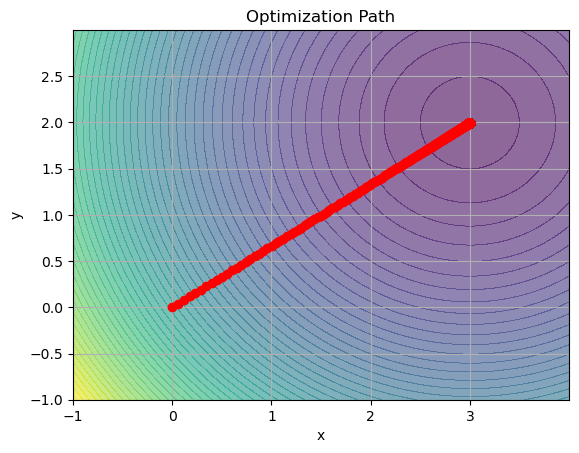

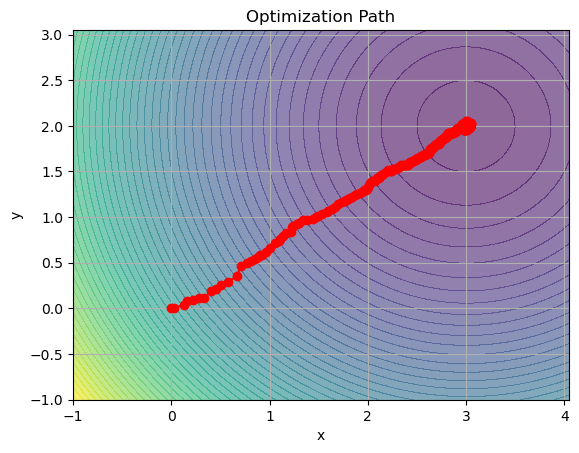

In [28]:
gd_optimizer.plot_history(lambda w: linear_regression_loss(w, X, y))
sgd_optimizer.plot_history(lambda w: linear_regression_loss(w, X, y))

## Real-world Example

In this example, we will use the Breast Cancer dataset from scikit-learn to train a neural network to classify whether a tumor is malignant or benign. We will compare the performance of the `SGD` optimizer and the `Adam` optimizer, which is an adaptive learning rate optimization algorithm that is based on the momentum and RMSprop algorithms. We will use the `BCELoss` loss function, which is the binary cross-entropy loss function, and the `Sigmoid` activation function, which is used to convert the output of the neural network to a probability.

In [29]:
# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Make y shape (n_samples, 1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

Here we define a simple neural network with one hidden layer. In the `forward` method of the `CancerClassifier` class, we pass the input through a linear layer with 32 units and a ReLU activation function, then through another linear layer with 16 units and a ReLU activation function, and finally through a linear layer with 1 unit and a Sigmoid activation function.

In [30]:
class CancerClassifier(nn.Module):
    def __init__(self, input_dim):
        super(CancerClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

We first train the neural network using the `SGD` optimizer and then evaluate its performance on the test set.

In [31]:
# Initialize model, loss, and optimizer
model = CancerClassifier(input_dim=X.shape[1])
loss_fn = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training loop
epochs = 500
for epoch in range(epochs):
    # Forward pass
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

Epoch 0/500, Loss: 0.7020
Epoch 10/500, Loss: 0.7013
Epoch 20/500, Loss: 0.7006
Epoch 30/500, Loss: 0.6999
Epoch 40/500, Loss: 0.6993
Epoch 50/500, Loss: 0.6986
Epoch 60/500, Loss: 0.6979
Epoch 70/500, Loss: 0.6973
Epoch 80/500, Loss: 0.6966
Epoch 90/500, Loss: 0.6959
Epoch 100/500, Loss: 0.6953
Epoch 110/500, Loss: 0.6946
Epoch 120/500, Loss: 0.6939
Epoch 130/500, Loss: 0.6933
Epoch 140/500, Loss: 0.6926
Epoch 150/500, Loss: 0.6919
Epoch 160/500, Loss: 0.6913
Epoch 170/500, Loss: 0.6906
Epoch 180/500, Loss: 0.6899
Epoch 190/500, Loss: 0.6892
Epoch 200/500, Loss: 0.6886
Epoch 210/500, Loss: 0.6879
Epoch 220/500, Loss: 0.6872
Epoch 230/500, Loss: 0.6866
Epoch 240/500, Loss: 0.6859
Epoch 250/500, Loss: 0.6852
Epoch 260/500, Loss: 0.6846
Epoch 270/500, Loss: 0.6839
Epoch 280/500, Loss: 0.6832
Epoch 290/500, Loss: 0.6825
Epoch 300/500, Loss: 0.6818
Epoch 310/500, Loss: 0.6812
Epoch 320/500, Loss: 0.6805
Epoch 330/500, Loss: 0.6798
Epoch 340/500, Loss: 0.6791
Epoch 350/500, Loss: 0.6784
Epo

In [32]:
with torch.no_grad():
    y_pred_test = model(X_test)
    y_pred_labels = (y_pred_test > 0.5).float()
    accuracy = (y_pred_labels == y_test).float().mean()
    print(f"Test Accuracy with SGD: {accuracy.item():.4f}")

Test Accuracy with SGD: 0.7018


Then we train the neural network using the `Adam` optimizer and evaluate its performance on the test set.

In [33]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 500
for epoch in range(epochs):
    # Forward pass
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

Epoch 0/500, Loss: 0.6679
Epoch 10/500, Loss: 0.6062
Epoch 20/500, Loss: 0.5343
Epoch 30/500, Loss: 0.4525
Epoch 40/500, Loss: 0.3706
Epoch 50/500, Loss: 0.2979
Epoch 60/500, Loss: 0.2377
Epoch 70/500, Loss: 0.1904
Epoch 80/500, Loss: 0.1549
Epoch 90/500, Loss: 0.1294
Epoch 100/500, Loss: 0.1111
Epoch 110/500, Loss: 0.0977
Epoch 120/500, Loss: 0.0877
Epoch 130/500, Loss: 0.0798
Epoch 140/500, Loss: 0.0734
Epoch 150/500, Loss: 0.0682
Epoch 160/500, Loss: 0.0639
Epoch 170/500, Loss: 0.0601
Epoch 180/500, Loss: 0.0569
Epoch 190/500, Loss: 0.0540
Epoch 200/500, Loss: 0.0513
Epoch 210/500, Loss: 0.0488
Epoch 220/500, Loss: 0.0465
Epoch 230/500, Loss: 0.0442
Epoch 240/500, Loss: 0.0420
Epoch 250/500, Loss: 0.0399
Epoch 260/500, Loss: 0.0379
Epoch 270/500, Loss: 0.0359
Epoch 280/500, Loss: 0.0340
Epoch 290/500, Loss: 0.0322
Epoch 300/500, Loss: 0.0305
Epoch 310/500, Loss: 0.0289
Epoch 320/500, Loss: 0.0273
Epoch 330/500, Loss: 0.0258
Epoch 340/500, Loss: 0.0244
Epoch 350/500, Loss: 0.0231
Epo

In [34]:
with torch.no_grad():
    y_pred_test = model(X_test)
    y_pred_labels = (y_pred_test > 0.5).float()
    accuracy = (y_pred_labels == y_test).float().mean()
    print(f"Test Accuracy with Adam: {accuracy.item():.4f}")

Test Accuracy with Adam: 0.9737


We noticed that the even though the model is the same, the optimizer used to train the model can have a significant impact on the performance of the model. In this case, the `Adam` optimizer achieved a higher test accuracy than the `SGD` optimizer.